<a href="https://colab.research.google.com/github/shubhamk16/Deep_learning/blob/master/A6_L2_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-2.0, 2.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             864
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             120
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,080
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

In [0]:
from tqdm import tqdm_notebook,tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR
import numpy as np
weight_decay = np.arange(0.005,0.1,0.5)
model =  Net().to(device)

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
  #tqdm._instances.clear()
  for i in weight_decay:
    print("EPOCH:", epoch)
    print("weight_decay:", i)
    optimizer = torch.optim.SGD(model.parameters(), lr= 0.01, momentum=0.92, dampening=0, weight_decay= i , nesterov=False)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
weight_decay: 0.005


Loss=0.1364317536354065 Batch_id=468 Accuracy=87.48: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1107, Accuracy: 9740/10000 (97.40%)

EPOCH: 1
weight_decay: 0.005


Loss=0.049921855330467224 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0604, Accuracy: 9859/10000 (98.59%)

EPOCH: 2
weight_decay: 0.005


Loss=0.11064591258764267 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9775/10000 (97.75%)

EPOCH: 3
weight_decay: 0.005


Loss=0.11759532243013382 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9880/10000 (98.80%)

EPOCH: 4
weight_decay: 0.005


Loss=0.06805231422185898 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9817/10000 (98.17%)

EPOCH: 5
weight_decay: 0.005


Loss=0.032940227538347244 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Accuracy: 9867/10000 (98.67%)

EPOCH: 6
weight_decay: 0.005


Loss=0.11834144592285156 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9834/10000 (98.34%)

EPOCH: 7
weight_decay: 0.005


Loss=0.11045986413955688 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9866/10000 (98.66%)

EPOCH: 8
weight_decay: 0.005


Loss=0.09082571417093277 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:13<00:00, 34.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9872/10000 (98.72%)

EPOCH: 9
weight_decay: 0.005


Loss=0.039749130606651306 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0932, Accuracy: 9777/10000 (97.77%)

EPOCH: 10
weight_decay: 0.005


Loss=0.056186169385910034 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9845/10000 (98.45%)

EPOCH: 11
weight_decay: 0.005


Loss=0.029553530737757683 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9892/10000 (98.92%)

EPOCH: 12
weight_decay: 0.005


Loss=0.061238888651132584 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0827, Accuracy: 9804/10000 (98.04%)

EPOCH: 13
weight_decay: 0.005


Loss=0.08865249902009964 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9908/10000 (99.08%)

EPOCH: 14
weight_decay: 0.005


Loss=0.042317137122154236 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 35.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9849/10000 (98.49%)

EPOCH: 15
weight_decay: 0.005


Loss=0.055230434983968735 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0863, Accuracy: 9817/10000 (98.17%)

EPOCH: 16
weight_decay: 0.005


Loss=0.07402489334344864 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9875/10000 (98.75%)

EPOCH: 17
weight_decay: 0.005


Loss=0.05851595103740692 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9835/10000 (98.35%)

EPOCH: 18
weight_decay: 0.005


Loss=0.039933040738105774 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 41.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9898/10000 (98.98%)

EPOCH: 19
weight_decay: 0.005


Loss=0.056998785585165024 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9878/10000 (98.78%)

EPOCH: 20
weight_decay: 0.005


Loss=0.10447784513235092 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9875/10000 (98.75%)

EPOCH: 21
weight_decay: 0.005


Loss=0.09664324671030045 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9867/10000 (98.67%)

EPOCH: 22
weight_decay: 0.005


Loss=0.11726047843694687 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9885/10000 (98.85%)

EPOCH: 23
weight_decay: 0.005


Loss=0.03399045392870903 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:13<00:00, 34.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9864/10000 (98.64%)

EPOCH: 24
weight_decay: 0.005


Loss=0.06871813535690308 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0483, Accuracy: 9901/10000 (99.01%)

EPOCH: 25
weight_decay: 0.005


Loss=0.0850098505616188 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:13<00:00, 41.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0431, Accuracy: 9911/10000 (99.11%)

EPOCH: 26
weight_decay: 0.005


Loss=0.05733982101082802 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9850/10000 (98.50%)

EPOCH: 27
weight_decay: 0.005


Loss=0.08783254772424698 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9891/10000 (98.91%)

EPOCH: 28
weight_decay: 0.005


Loss=0.07708841562271118 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9905/10000 (99.05%)

EPOCH: 29
weight_decay: 0.005


Loss=0.04834282770752907 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0404, Accuracy: 9905/10000 (99.05%)

EPOCH: 30
weight_decay: 0.005


Loss=0.07474301755428314 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9851/10000 (98.51%)

EPOCH: 31
weight_decay: 0.005


Loss=0.05152956768870354 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9825/10000 (98.25%)

EPOCH: 32
weight_decay: 0.005


Loss=0.039380915462970734 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0456, Accuracy: 9898/10000 (98.98%)

EPOCH: 33
weight_decay: 0.005


Loss=0.12202795594930649 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9873/10000 (98.73%)

EPOCH: 34
weight_decay: 0.005


Loss=0.06829117238521576 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9848/10000 (98.48%)

EPOCH: 35
weight_decay: 0.005


Loss=0.041438113898038864 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9895/10000 (98.95%)

EPOCH: 36
weight_decay: 0.005


Loss=0.09538630396127701 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9867/10000 (98.67%)

EPOCH: 37
weight_decay: 0.005


Loss=0.05724343657493591 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:13<00:00, 40.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0516, Accuracy: 9877/10000 (98.77%)

EPOCH: 38
weight_decay: 0.005


Loss=0.07170934975147247 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9889/10000 (98.89%)

EPOCH: 39
weight_decay: 0.005


Loss=0.08856799453496933 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]



Test set: Average loss: 0.0513, Accuracy: 9886/10000 (98.86%)



Text(0.5, 1.0, 'Test Accuracy')

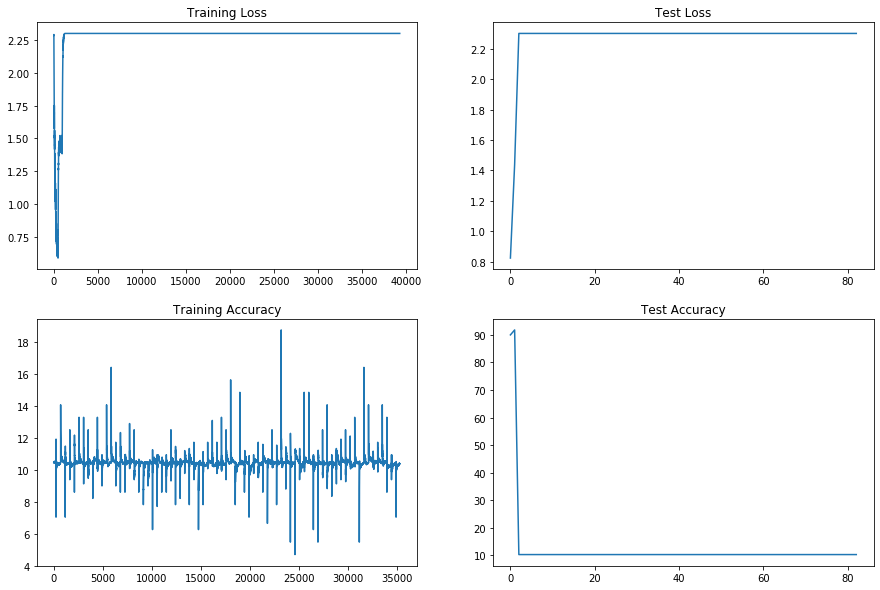

In [0]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import numpy as np
np.arange(0.005,0.1,0.5)

array([0.005])